# Classification of Play Type in NFL Play-By-Play Data

### Ian Johnson, Derek Phanekham, Travis Siems

## Introduction

The NFL (National Football League) has 32 teams split into two conferences, the AFC and NFC. Each of the 32 teams plays 16 games during the regular season (non-playoff season) every year. Due to the considerable viewership of American football, as well as the pervasiveness of fantasy football, considerable data about the game is collected. During the 2015-2016 season, information about every play from each game that occurred was logged. All of that data was consolidated into a single data set which is analyzed throughout this report.

In this report, we will attempt to classify the type of a play, given the game situation before the play began. 

### The Classification Task

We will attempt to classify plays based on play type using information about the state of the game prior to the start of the play. This is expected to be an exceptionally difficult classification task, due to the amount of noise in the dataset (specifically, the decision to run vs pass the ball is often a seemingly random one). A successful classifier would have huge value to defensive coordinators, who could call plays based on the expected offensive playcall. Because it may be very difficult to identify what play will be called, it is relevant to provide a probability of a given playcall in a situation. For example, it would be useful to provide the probability of a 4th down conversion attempt, even if the overall prediction is that a punt occurs. 

### Data Preparation

In order to prepare the data for classification, a number of variables from the original dataset will be removed, as they measure the result of the play, not the state of the game prior to the start of the play. The dataset being included in this report has had previous cleaning and preprocessing performed in our previous report.

In [3]:
#For final version of report, remove warnings for aesthetics.
import warnings
warnings.filterwarnings('ignore')

#Libraries used for data analysis
import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('data/cleaned.csv') # read in the csv file

colsToInclude = ['GameID', 'Drive', 'qtr', 'down',
                 'TimeSecs', 'yrdline100','ydstogo','ydsnet',
                 'GoalToGo','posteam','DefensiveTeam',
                 'PosTeamScore','ScoreDiff', 'PlayType']

df = df[colsToInclude]
df = df[[p not in ["Sack", "No Play", "QB Kneel", "Spike"] for p in df.PlayType]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38600 entries, 0 to 42875
Data columns (total 14 columns):
GameID           38600 non-null int64
Drive            38600 non-null int64
qtr              38600 non-null int64
down             38600 non-null int64
TimeSecs         38600 non-null float64
yrdline100       38600 non-null float64
ydstogo          38600 non-null float64
ydsnet           38600 non-null float64
GoalToGo         38600 non-null int64
posteam          38600 non-null object
DefensiveTeam    38600 non-null object
PosTeamScore     38600 non-null float64
ScoreDiff        38600 non-null float64
PlayType         38600 non-null object
dtypes: float64(6), int64(5), object(3)
memory usage: 4.4+ MB


A subset of attributes will be one-hot encoded, as they are categorical variables which won't work with our classification algorithm. The following Python function was used for one-hot encoding, and was adapted from the website referenced in the code.

In [4]:
from sklearn.feature_extraction import DictVectorizer

#Simple function for 1 hot encoding
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

df = encode_onehot(df, cols=['posteam', 'DefensiveTeam'])

The following are descriptions of the remaining data columns in the play-by-play dataset. Note that the one-hot encoded columns do not follow the structure listed below, but for the sake of readability they are presented as if they were not one-hot encoded.

* **GameID** (*nominal*): A unique integer which identifies each game played 
* **Drive** (*ordinal*): The number of the drive during a game when the play occurred (indexed at one, so the first drive of the game has Drive 1 and the nth drive has Drive n)
* **qtr** (*interval*): The quarter of the game when the play occurred
* **down** (*interval*): The down when the play occurred (1st, 2nd, 3rd, or 4th)
* **TimeSecs** (*interval*): The remaining game time, in seconds, when the play began
* **yrdline100** (*ratio*): The absolute yard-line on the field where the play started (from 0 to 100, where 0 is the defensive end zone and 100 is the offensive end zone of the team with the ball)
* **ydstogo** (*ratio*): The number of yards from the line of scrimmage to the first-down line
* **ydsnet** (*ratio*): The number of yards from the beginning of the drive to the current line of scrimmage
* **GoalToGo** (*nominal*): A binary attribute whose value is 1 if there is no first down line (the end-zone is the first down line) or 0 if there is a normal first down line
* **posteam** (*nominal*): A 2-or-3 character code representing the team on offense
* **PosTeamScore** (*ratio*): The score of the team with possesion of the ball
* **DefensiveTeam** (*nominal*): A 2-or-3 character code representing the team on defense
* **ScoreDiff**: (*ratio*) The difference in score between the offensive and defensive at the time of the play.
* **PlayType**: (*nominal*) An attribute that identifies the type of play (i.e. Kickoff, Run, Pass, Sack, etc)

### Performance Metrics

The value of a classifier will be evaulated using the following cost matrix. Costs in the matrix which are set to 1 represent play predictions that would never actually occur in the context of a football game. For example, if we predicted a pass play and a kickoff occurs, then the classifier has a significant flaw. 

Bolded weights represent actual mispredictions that could occur.

|                | Actual Play | Pass | Run | Kickoff |     Punt    | Extra Point | Field Goal | Onside Kick |
|----------------|-------------|------|-----|---------|-------------|------------|-------------|-------------|
| Predicted Play |             |      |     |         |             |            |             | |
| Pass           |             | 0    | **0.1** | 1       | **0.15** | **0.15**        | **0.1**         | 1           |  
| Run            |             | **0.1**  | 0   | 1       | **0.15** | **0.15**        | **0.1**         | 1           | 
| Kickoff        |             | 1    | 1   | 0     |  1  | 1           | 1          | **0.75**       |
| Punt           |             | **0.25**    | **0.25**   | 1   | 0 |1       |  **0.15**           | 1           |
| Extra Point    |             | **0.4**  | **0.4** | 1       | 1 | 0           | 1          | 1           |
| Field Goal     |             | **0.4** | **0.4** | 1       | **0.1** | 1           | 0          | 1           |
| Onside Kick    |             | 1    | 1   | **0.25**    |  1 |1           | 1          | 0           |


This performance metric is the best for this classification problem because the actual potential cost of an incorrect play prediction varies significantly based on the nature of the misclassification. In an actual football game, it would be very costly to predict an extra point and have the opposing team run a pass play. This means that they ran a fake extra point and went for a two-point conversion. However, if a pass play is predicted and a run play occurs, the cost of the error is minimal because the defensive strategy for defending against run and pass plays.

Because the goal of this classification is to help inform defensive play-calling, a cost matrix is helpful because it allows a defensive coordinator to set his own costs to produce his own classifier, without any knowledge of the actualy computation that occurs.

### Cross Validation Methodology

We will use a stratified 10-fold cross validation technique to compare the models. We use a sequential partition of the data because this mirrors how data will be collected and analyzed. For our use, we assume that it is okay to use data in the “future” to predict data “now” because it can represent data from a previous football season. This stratified sample will reduce variance in the estimation. 

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#Using a 10-fold stratified shuffle split.
cv = StratifiedKFold(n_splits=10)

y = df.PlayType.values
X = df.drop('PlayType', 1).values

## Modeling

Before we build any models, we define a cost function in Python below, which is used to test all of our forthcoming models. It computes the item-wise product of a confusion matrix and our cost matrix, and returns the sum of all of the elements in the resulting matrix.

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

cost_mat =     [[0  ,.1  , 1   , .15 , 0.15, .1 , 1   ],
                [.1 , 0  , 1   , 0.15, 0.15, 0.1, 1   ],
                [1  , 1  , 0   , 1   , 1   , 1  , 0.75],
                [.25,0.25, 1   , 0   , 1   ,0.15,  1  ],
                [0.4, 0.4, 1   , 1   , 0   , 1  ,  1  ],
                [0.4, 0.4, 1   , 0.1 , 1   , 0  ,  1  ],
                [1  , 1  , 0.25, 1   , 1   , 1  ,  0  ]]

def cost(Y, yhat):
    
    return np.sum(np.multiply(confusion_matrix(Y,yhat), cost_mat))

scorer = make_scorer(cost)

### An Accessory Plotting Function

The following plotting function will be used for tuning hyperparameters for various algorithms.
It is adapted from one of the instructional ML notebooks for CSE 5393

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')

#Adapted From MachineLearningNotebooks/09_Evaluation
#Credit: Dr. Eric Larson
def plot_filled(train_scores,test_scores,train_x_axis, xlabel=''):

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_x_axis, test_mean,
             color='blue', marker='o',
             markersize=5, label='testing cost')

    plt.fill_between(train_x_axis,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='blue')

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel('Cost')
    plt.legend(loc='upper right')

### Logistic Regression

The first model we will use is a logistic regression model. Before creating the final model, we will tune the cost variable C using a validation curve generated with the cross validation strategy described above. For both the hyperparameter tuning and the final model creation, we will use a class weight dictionary to encode the costs of each class. These costs will be computed using the row sums of the cost matrix.

In [8]:
#Building the class weight map
PlayTypes = df.PlayType.value_counts().index.tolist()
Costs = [sum(x) for x in cost_mat]

ClassWeights = dict(zip(PlayTypes, Costs))

In [9]:
#Some includes
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [13]:
#Note: This takes a long time to run. Don't re-run it unless you have to!

#create pipeline of scaling and logistic regression
clf = Pipeline([('sca',StandardScaler()),
                ('clf',LogisticRegression(class_weight=ClassWeights))])

#Some possible values of 
param_range = [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

train_scores, test_scores = validation_curve(
                estimator=clf, 
                X=X, 
                y=y, 
                param_name='clf__C', 
                param_range=param_range,
                scoring=scorer,
                cv=cv,
                n_jobs=-1)

In order to assess the optimal value of C, we plot the value of C vs the cost of the produced classifier:

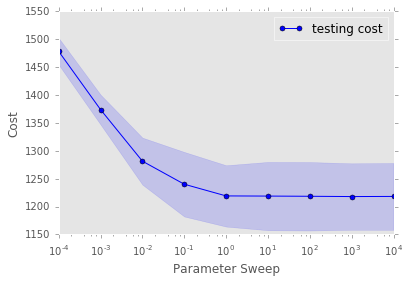

In [14]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

Based on the above plot, we can see that the (approximate) optimal value of C is 1. While larger values of C don't percievably change the training cost, they do introduce a larger variance, and likely result in more overfitting. Therefore, C will be set to 1 for our final Logistic Regression model.

In [10]:
#Note: This takes a long time to run. Don't re-run it unless you have to!

#Re-define the pipeline, this time with the tuned value of C (C=1)
clf = Pipeline([('sca',StandardScaler()),
                ('clf',LogisticRegression(C=1, class_weight = ClassWeights))])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=scorer
                                   )

Mean Cost:  1219.1


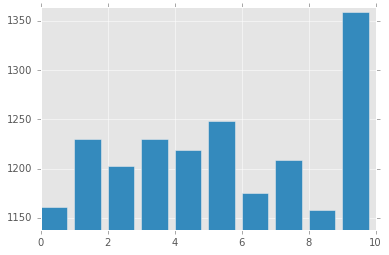

In [11]:
#Plot the costs of the evaluations on each fold
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-20,max(per_fold_eval_criteria)+5])
print("Mean Cost: ", np.mean(per_fold_eval_criteria))

LogisticRegressionCosts = per_fold_eval_criteria

The above plot shows the costs of the models built and evaluated on each of the ten folds. Note that the y-axis is not zeroed at zero, so the relative heights of the models is not meaningful. The mean cost for the logistic regression models was 3368.4

### Support Vector Machine

Our next model will use a support vector machine with the RBF kernel. We will tune the hyper-parameters C and gamma for the SVM using the same method used for tuning the logistic regression model. The same cost metric and cross-validation strategy will be used for the SVM as was used for logistic regression.

In [15]:
from sklearn.svm import SVC

In [16]:
#Note: This takes a VERY long time to run. Don't re-run it unless you have to!

#create pipeline of scaling and logistic regression
clf = Pipeline([('sca',StandardScaler()),
                ('clf',SVC(class_weight=ClassWeights, kernel='rbf'))])

#Some possible values of C. Fewer values are used because this takes forever to run.
param_range = [.01, .1, 1, 10]

train_scores, test_scores = validation_curve(
                estimator=clf, 
                X=X, 
                y=y, 
                param_name='clf__C', 
                param_range=param_range,
                scoring=scorer,
                cv=cv,
                n_jobs=-1)

Once again, we plot the value of C vs the cost of the produced classifier to identify the optimal value of C

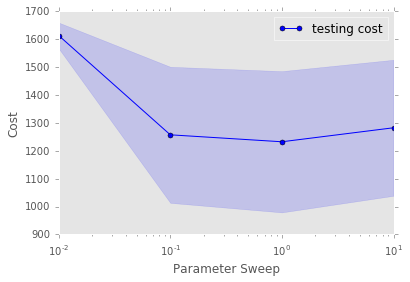

In [17]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

Once again, we identify that the optimal value of C for the SVM Classifier is 1. At C=1, we have the lowest cost, but we have a high variance in cost. However, the upper-bound of the cost at C=1 is still lower than the upper bound for all other values of C. Therefore, our final SVM classifier will be built using a C of 1. Next, the gamma variable will be tuned, using the same process that was used for tuning C. Note that tuning the parameters in order like this may not result in an optimal solution. However, it is the only way to tune the hyperparameters in a feasible amount of time.

In [ ]:
#Note: This takes a VERY long time to run. Don't re-run it unless you have to!

#create pipeline of scaling and logistic regression
clf = Pipeline([('sca',StandardScaler()),
                ('clf',SVC(class_weight=ClassWeights, kernel='rbf', C=1))])

#Some possible values of gamma. 1/76 is default (1/num_attributes)
param_range = [1/10000, 1/1000 , 1/76, 1/10, 1]

train_scores, test_scores = validation_curve(
                estimator=clf, 
                X=X, 
                y=y, 
                param_name='clf__gamma', 
                param_range=param_range,
                scoring=scorer,
                cv=cv,
                n_jobs=-1)

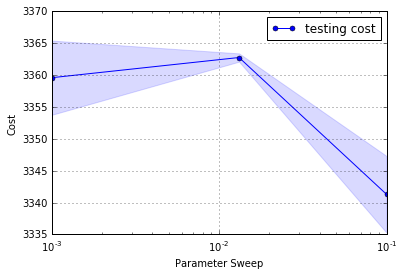

In [33]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

The above plot shows that the optimal value of gamma, in this case, is 1/10. Note that only a few values of gamma were evaluated, due to the significant time required to test each possible value of gamma.

In [9]:
#Note: This takes a long time to run. Don't re-run it unless you have to!

#Re-define the pipeline, this time with the tuned value of C (C=1) and gamma (gamma=0.1)
clf = Pipeline([('sca',StandardScaler()),
                ('clf',SVC(C=1, class_weight = ClassWeights, gamma=0.1))])

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=scorer,
                                    n_jobs=-1
                                   )

Mean Cost:  3336.37


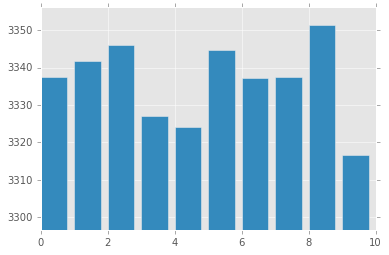

In [12]:
#Plot the costs of the evaluations on each fold
plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-20,max(per_fold_eval_criteria)+5])
print("Mean Cost: ", np.mean(per_fold_eval_criteria))

SVMCosts = per_fold_eval_criteria

The above plot shows the costs of each of the 10 folds of testing data when run against a model trained with the remaining 9 folds. The costs of this model are saved for comparison against the other algorithms in later analysis. The mean cost of this model is slightly lower than the mean cost of the logistic regression model; however, this may not be statistically meaningful. That will be explored in later sections.

### Multi-Layer Perceptron

In [15]:
from sklearn.neural_network import MLPClassifier

In [17]:
#Note: This takes a VERY long time to run. Don't re-run it unless you have to!

#create pipeline of scaling and logistic regression
clf_neural = Pipeline([('sca',StandardScaler()),
                ('clf',MLPClassifier())])

param_range = [1, 10, 100, 1000]

train_scores, test_scores = validation_curve(
                estimator=clf_neural, 
                X=X, 
                y=y, 
                param_name='clf__hidden_layer_sizes', 
                param_range=param_range,
                scoring=scorer,
                cv=cv,
                n_jobs=-1)

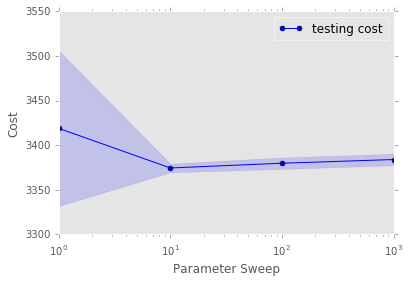

In [18]:
plot_filled(train_scores, test_scores, param_range, xlabel='Parameter Sweep')
plt.xscale('log')
plt.show()

### LAST SKLEARN CLASSIFIER

### Classifier Comparison

### Ensemble Classifier

### Comparison of Ensemble to Original Classifiers

## Deployment

## An Additional Classifier

For the sake of comparison, one non-sklearn classifier will be used on the dataset. An association-rule-based classifier from R package arulesCBA is used to train a model on the dataset and predict one fold of the dataset in the following R code: 

```
df <- read.csv("data/cleaned.csv", stringsAsFactors = TRUE)
df <- df[c('GameID', 'Drive', 'qtr', 'down','TimeSecs', 'yrdline100','ydstogo','ydsnet','GoalToGo','posteam','DefensiveTeam','PosTeamScore','ScoreDiff', 'PlayType')]

df <- df[(df$PlayType != "Sack"),]
df <- df[(df$PlayType != "No Play"),]
df <- df[(df$PlayType != "QB Kneel"),]
df <- df[(df$PlayType != "Spike"),]
df$PlayType <- factor(df$PlayType)

df[c("GameID", "Drive","qtr","down","GoalToGo","posteam","DefensiveTeam","PlayType")] <- sapply(df[c("GameID", "Drive","qtr","down","GoalToGo","posteam","DefensiveTeam","PlayType")], as.factor)

library(arulesCBA)

df[c("TimeSecs", "yrdline100","ydstogo","ydsnet","PosTeamScore","ScoreDiff")] <- sapply(df[c("TimeSecs", "yrdline100","ydstogo","ydsnet","PosTeamScore","ScoreDiff")], function(x) discretize(x, categories = 5))
df <- as.data.frame(sapply(df, as.factor))

classifier <- CBA(df[1:34740,], "PlayType", support=0.04, maxtime=0.05, confidence = 0.80)
results <- predict(classifier, df[34741:38600,])

library(caret)
conf <- confusionMatrix(results, df$PlayType[34741:38600])[[2]]

write.csv(conf, file="data/confusion.csv", row.names = FALSE, col.names = FALSE)
```

The arulesCBA classifier was used because we beleived that a rule-based classification strategy would work well for this classification problem. Below, the cost of the model for a single fold is calculated. Note that because stratified folding was not used, and only one fold was evaluated, we can't compare this model to the existing models with statistical significance.

In [ ]:
confMat = pd.read_csv('data/confusion.csv')